In [1]:
import os
import time
import pandas as pd
import numpy as np
import networkx as nx
import collections
from scipy import sparse as sp
from scipy.stats import rankdata

import itertools
from itertools import combinations, combinations_with_replacement, cycle
from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from util import *

import colorcet as cc

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
hemibrain_version = "v1.2.1"
log_msg("Hemibrain data set being used:", hemibrain_version)

preproc_dir = "oviIN/preprocessed-" + hemibrain_version
preproc_nodes = "preprocessed_nodes.csv"
preproc_centroids = "x"
preproc_edges = "preprocessed_undirected_edges.csv"

hemibrain_dir = "oviIN/clustering_" + hemibrain_version
hemibrain_nodes = "inputsoutputs_key.txt"
hemibrain_edges = "inputsoutputs.txt"
#hemibrain_nodes = "only_inputs_key.txt"
#hemibrain_edges = "only_inputs.txt"
#hemibrain_nodes = "only_outputs_key.txt"
#hemibrain_edges = "only_outputs.txt"

figure_dir = os.path.join("figures","paper")
movie_dir = os.path.join("movies")
analysis_dir = os.path.join("analysis",hemibrain_version)
obj_dir = os.path.join("obj",hemibrain_version)  # 3d objects from, e.g. fetch_roi_mesh
skel_dir = os.path.join("skeleton", hemibrain_version)  # skeleta of neurons in .csv format


for d in [figure_dir, analysis_dir, obj_dir, movie_dir]:
    if not os.path.isdir(d):
        log_msg("Creating directory", d)
        os.makedirs(d)

reneel_params = list(sorted(['0.0', '0.1','0.5','0.75'], key=float))
type_params = ['celltype','instance']
list_of_params = reneel_params + type_params

log_msg("Set up directory info and useful lists")

2024 01 24 16:53:39  Hemibrain data set being used: v1.2.1
2024 01 24 16:53:39  Creating directory figures/paper
2024 01 24 16:53:39  Creating directory analysis/v1.2.1
2024 01 24 16:53:39  Creating directory obj/v1.2.1
2024 01 24 16:53:39  Creating directory movies
2024 01 24 16:53:39  Set up directory info and useful lists


In [3]:
from neuprint import Client
from neuprint import fetch_roi_hierarchy


auth_token_file = open("flybrain.auth.txt", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + hemibrain_version, token=auth_token)
    log_msg("neuprint Client set up as `np_Client`, version", np_client.fetch_version())
except:
    np_client = None
    log_msg("neuprint Client set up failed!")

2024 01 24 16:53:40  neuprint Client set up as `np_Client`, version 0.1.0


In [7]:
log_msg("Loading node dataframe")
if os.path.isfile(os.path.join(preproc_dir, preproc_centroids)):
    log_msg("  (with centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_centroids), index_col=0)
else:
    log_msg("  (without centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_nodes), index_col=0)
log_msg("Adding 'type group'")
HB_node_df["type_group"] = HB_node_df["celltype"]
log_msg("Done!")

log_msg("Loading directed edges from csv")
HB_edge_df = pd.read_csv(os.path.join(hemibrain_dir, hemibrain_edges), delimiter=' ', header=None).rename(columns={0: "pre", 1:"post"})
log_msg("Done!")

log_msg("Merging in cell info to edge df")
HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='pre', right_index=True)
HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='post', right_index=True, suffixes=['pre', 'post'])
log_msg("Done!")

2024 01 24 16:59:57  Loading node dataframe
2024 01 24 16:59:57    (without centroids)
2024 01 24 16:59:57  Adding 'type group'
2024 01 24 16:59:57  Done!
2024 01 24 16:59:57  Loading directed edges from csv
2024 01 24 16:59:57  Done!
2024 01 24 16:59:57  Merging in cell info to edge df
2024 01 24 16:59:57  Done!


In [8]:
# Creates the list of the correct clusters that aligns to specified clusters
def create_lists(clusters, chi):
    list_point1 = []
    for i in clusters:
        list_point1.append(HB_node_df[HB_node_df[chi]==i].index.tolist())
    return list_point1

# Calculates certain differences between the different lists of neurons
def calculate_difference(list1, list2):
    set1 = set(list1)
    set2 = set(list2)

    unique_1 = set1-set2
    unique_2 = set2-set1

    common = set1.intersection(set2)
    total_unique = len(unique_1) + len(unique_2)
    jaccard_sim = len(common) / (total_unique + len(common))

    return unique_1, unique_2, common, jaccard_sim

# Create dictionary from lists
def create_dictionary(clusters, zero_cluster, cluster_number):
    dictionary = {}
    for i, cluster in enumerate(clusters):
        dictionary[cluster_number[i]] = {
            'cluster': cluster,
            'zero_cluster': zero_cluster[i],
            'cluster_number': cluster_number[i]
        }
    return dictionary

# Compiles all functions into one and prints out the information
def analysis(dictionary_oflists, chi, network, graph_name):
    jaccard_sim = []
    clusters = []
    # Pull items from dictionary 
    for key, item in dictionary_oflists.items():
        cluster = item['cluster']
        zero_cluster = item['zero_cluster']
        cluster_number=item['cluster_number']
        
        # create list of neuron lists using inputted chi value
        list_point=create_lists(cluster, chi)
        list_point1 = list(itertools.chain.from_iterable(list_point))
        unique_1, unique_2, common_one, jaccard_sim_one = calculate_difference(list_point1, zero_cluster)

        # Print out information
        print("\nThis is information about clusters {} compared with cluster {}".format(cluster, cluster_number))
        print('Neurons unique to clusters at chi value of 0.1: ', len(unique_1))
        print('Neurons unique to chi value of 0.0 of cluster 1: ', len(unique_2))
        print('Length of common neurons:', len(common_one))
        print("Jaccard similarity between zero cluster 1 and 0.1:", jaccard_sim_one)

        # Remember jaccard similarities and cluster numbers
        jaccard_sim.append(jaccard_sim_one)
        clusters.append(cluster_number)
    
    # Create figure for the jaccard similarity information
    plt.scatter(clusters, jaccard_sim)
    plt.title('Jaccard Similarities for {a} in the {b} network'.format(a=chi, b=network))
    plt.locator_params(axis='x', nbins=6)
    plt.locator_params(axis='y', nbins=8)
    plt.savefig(graph_name)
    plt.show()

palette = cc.glasbey_dark
larval_color_override = {}
def larval_color_mapper(c, chi):
    """Color mapper for clusters of larval MB. Only accepts numerical `c`"""
    skip = sum(HB_node_df[x].max() for x in reneel_params if float(x) < float(chi))
    default = palette[(c + skip) % len(palette)]
    return larval_color_override.get(chi, {}).get(c, default)

larval_color_override = {"0.25": {1:  larval_color_mapper(1, "0.0"),
                                7:  larval_color_mapper(2, "0.0"),
                                3:  larval_color_mapper(3, "0.0"),
                                11: larval_color_mapper(5, "0.0"),
                                4:  larval_color_mapper(4, "0.0")}}
larval_color_override["0.5"] = {1:  larval_color_mapper(1, "0.25"),
                            5:  larval_color_mapper(2, "0.25"),
                            4:  larval_color_mapper(3, "0.25"),
                            8:  larval_color_mapper(5, "0.25"),
                            13: larval_color_mapper(7, "0.25"),
                            23: larval_color_mapper(8, "0.25")}
    
reneel_params = list(sorted(['0.0', '0.05','0.1', '0.5', '0.75', '1.0'], key=float))




In [9]:
chi = "0.0"
HB_node_df[f"{chi}color"] = [larval_color_mapper(c, chi) for c in HB_node_df[chi]]


In [10]:
cond_df=HB_node_df[HB_node_df['0.0']==1]
#unique_clusters = cond_df[].unique().tolist()

In [11]:

pwd

'/Users/rhessa/flybrain-clustering'

In [12]:
# Assigning 0.1 clusters to corresponding low res cluster (full)
cluster1 = [1,2,4,47]
cluster2 = [3, 42, 133, 134]
cluster3 = [5]
cluster4 = [6, 115, 123]
cluster5 = [7, 12, 13, 67]
cluster6 = [8, 10, 48, 109]

# Cluster list for 0.1
cluster_pointone = [1,2,3,4,5,6]
clusters_list=[cluster1, cluster2, cluster3, cluster4, cluster5, cluster6]

# Pulling cluster for all clusters at 0.0
zero_cluster_list= create_lists(cluster_pointone, '0.0')

# Creating the dictionaries
dict_pointone=create_dictionary(clusters_list, zero_cluster_list, cluster_pointone)

# Assigning 0.05 clusters to corresponding low res cluster (full)
c1_point05 = [1,2,4]
c2_point05 = [3,33,77]
c3_point05 = [5]
c4_point05 = [7]
c5_point05 =[8,32]
c6_point05 = [9]

# Cluster list for 0.05
cluster_point05 = [1,2,3,4,5,6]
clusters_list_05=[c1_point05, c2_point05, c3_point05, c4_point05, c5_point05, c6_point05]

# Creating the dictionaries
dict_point05=create_dictionary(clusters_list_05, zero_cluster_list, cluster_point05)

# Assigning 0.5 clusters to corresponding low res clusters (inputs)
c1_point5 = []
c2_point5 = []
c3_point5 = []
c4_point5 = []
c5_point5 = []
c6_point5 = []

# Clusters list for 0.5
cluster_point5 = [1,2,3,4,5,6]
clusters_list_05=[c1_point5, c2_point5, c3_point5, c4_point5, c5_point5, c6_point5]


In [13]:
# Check dictionary for accuracy
def print_second_item(dictionary):
    items = list(dictionary.items())
    if len(items) >= 2:
        second_item = items[1]
        print(second_item)
    else:
        print("Dictionary does not have a second item.")

print_second_item(dict_pointone)

(2, {'cluster': [3, 42, 133, 134], 'zero_cluster': [1007640554, 1009578838, 1013425227, 1014824204, 1020608033, 1037979778, 1044459902, 1045525957, 1100381898, 1140003523, 1140996390, 1141328881, 1205220831, 1231299343, 1451401873, 1546155976, 203253253, 2192108884, 2223148195, 2316252927, 2409016548, 266187342, 266187383, 266187477, 266187480, 266187559, 266191407, 266528086, 266873591, 267214250, 267223104, 267551639, 267564140, 267568157, 267896360, 295802733, 295828029, 295849410, 296139882, 296194535, 296199026, 296199149, 296509709, 296838079, 296855409, 296859399, 296885362, 297166053, 297217528, 297230760, 297519815, 297541369, 297563139, 297563270, 297580589, 297584752, 297584869, 297588995, 297912117, 297917277, 297917363, 297917364, 297917459, 297917475, 297921570, 297921608, 297921808, 297925487, 297925526, 297925608, 297925628, 297929807, 297929902, 297929935, 297930068, 297934012, 297934349, 297938585, 297947227, 298241038, 298250090, 298254384, 298254474, 298254517, 2982

In [14]:
pwd

'/Users/rhessa/flybrain-clustering'


This is information about clusters [1, 2, 4, 47] compared with cluster 1
Neurons unique to clusters at chi value of 0.1:  277
Neurons unique to chi value of 0.0 of cluster 1:  187
Length of common neurons: 991
Jaccard similarity between zero cluster 1 and 0.1: 0.6810996563573883

This is information about clusters [3, 42, 133, 134] compared with cluster 2
Neurons unique to clusters at chi value of 0.1:  9
Neurons unique to chi value of 0.0 of cluster 1:  177
Length of common neurons: 605
Jaccard similarity between zero cluster 1 and 0.1: 0.7648546144121365

This is information about clusters [5] compared with cluster 3
Neurons unique to clusters at chi value of 0.1:  1
Neurons unique to chi value of 0.0 of cluster 1:  34
Length of common neurons: 345
Jaccard similarity between zero cluster 1 and 0.1: 0.9078947368421053

This is information about clusters [6, 115, 123] compared with cluster 4
Neurons unique to clusters at chi value of 0.1:  44
Neurons unique to chi value of 0.0 of clus

FileNotFoundError: [Errno 2] No such file or directory: 'oviIN/Figures-oviIN/full01_jaccard.png'

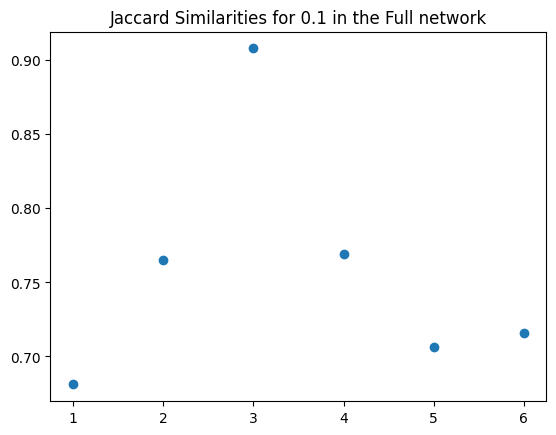

In [16]:
# Analysis comparison for 0.1 chi value of full network
analysis(dict_pointone, '0.1', 'Full', "oviIN/F/full01_jaccard.png")


This is information about clusters [1, 2, 4] compared with cluster 1
Neurons unique to clusters at chi value of 0.1:  316
Neurons unique to chi value of 0.0 of cluster 1:  94
Length of common neurons: 1084
Jaccard similarity between zero cluster 1 and 0.1: 0.7255689424364123

This is information about clusters [3, 33, 77] compared with cluster 2
Neurons unique to clusters at chi value of 0.1:  10
Neurons unique to chi value of 0.0 of cluster 1:  132
Length of common neurons: 650
Jaccard similarity between zero cluster 1 and 0.1: 0.8207070707070707

This is information about clusters [5] compared with cluster 3
Neurons unique to clusters at chi value of 0.1:  1
Neurons unique to chi value of 0.0 of cluster 1:  34
Length of common neurons: 345
Jaccard similarity between zero cluster 1 and 0.1: 0.9078947368421053

This is information about clusters [7] compared with cluster 4
Neurons unique to clusters at chi value of 0.1:  36
Neurons unique to chi value of 0.0 of cluster 1:  131
Length 

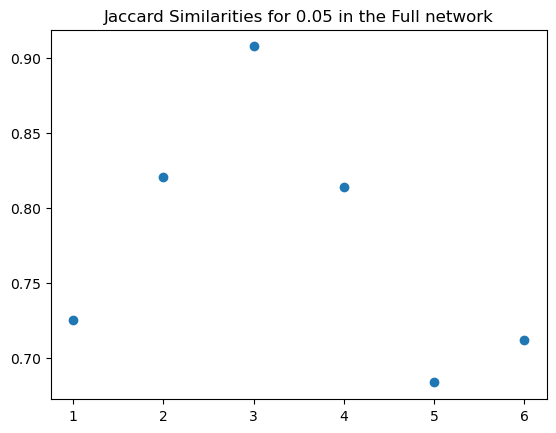

In [13]:
analysis(dict_point05, '0.05', 'Full', "oviIN/Figures/full005_jaccard.png")

In [14]:
## Inputs analysis
hemibrain_version = "v1.2.1"
log_msg("Hemibrain data set being used:", hemibrain_version)

preproc_dir = "oviIN/preprocessed_inputs-" + hemibrain_version
preproc_nodes = "preprocessed_nodes.csv"
preproc_centroids = "x"
preproc_edges = "preprocessed_undirected_edges.csv"

hemibrain_dir = "oviIN/clustering_inputs_" + hemibrain_version
hemibrain_nodes = "only_inputs_key.txt"
hemibrain_edges = "only_inputs.txt"

log_msg("Set up directory info and useful lists")

log_msg("Loading node dataframe")
if os.path.isfile(os.path.join(preproc_dir, preproc_centroids)):
    log_msg("  (with centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_centroids), index_col=0)
else:
    log_msg("  (without centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_nodes), index_col=0)
log_msg("Adding 'type group'")
HB_node_df["type_group"] = HB_node_df["celltype"].apply(simplify_type)
log_msg("Done!")

log_msg("Loading directed edges from csv")
HB_edge_df = pd.read_csv(os.path.join(hemibrain_dir, hemibrain_edges), delimiter=' ', header=None).rename(columns={0: "pre", 1:"post"})
log_msg("Done!")

log_msg("Merging in cell info to edge df")
HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='pre', right_index=True)
HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='post', right_index=True, suffixes=['pre', 'post'])

log_msg("Done!")

# Assigning 0.05 clusters to corresponding low res cluster (inputs)
c1_point05 = [6,15,21,23]
c2_point05 = [1,4,5,7,10,33]
c3_point05 = [2,3,8]
c4_point05 = [11]
c5_point05 =[20]

# Assigning 0.1 clusters to corresponding low res cluster (inputs)
cluster1 = [13]
cluster2 = [1,3,4,7,9,10,47]
cluster3 = [2,8]
cluster4 = [15]
cluster5 = [5]

# Assigning 0.5 clusters to corresponding low res clusters (inputs)
c1_point5 = []
c2_point5 = []
c3_point5 = []
c4_point5 = []
c5_point5 = []
c6_point5 = []

# Cluster list for 0.05
cluster_point05 = [1,2,3,4,5]
clusters_list_05=[c1_point05, c2_point05, c3_point05, c4_point05, c5_point05]

# Cluster list for 0.1
cluster_pointone = [1,2,3,4,5]
clusters_list=[cluster1, cluster2, cluster3, cluster4, cluster5]

# Clusters list for 0.5
cluster_point5 = [1,2,3,4,5,6]
clusters_list_05=[c1_point5, c2_point5, c3_point5, c4_point5, c5_point5, c6_point5]

# Pulling cluster for all clusters at 0.0
zero_cluster_list= create_lists(cluster_pointone, '0.0')

# Creating the dictionaries
dict_pointone=create_dictionary(clusters_list, zero_cluster_list, cluster_pointone)
dict_point05=create_dictionary(clusters_list_05, zero_cluster_list, cluster_point05)

2023 07 06 13:01:37  Hemibrain data set being used: v1.2.1
2023 07 06 13:01:37  Set up directory info and useful lists
2023 07 06 13:01:37  Loading node dataframe
2023 07 06 13:01:37    (without centroids)
2023 07 06 13:01:37  Adding 'type group'
2023 07 06 13:01:37  Done!
2023 07 06 13:01:37  Loading directed edges from csv
2023 07 06 13:01:37  Done!
2023 07 06 13:01:37  Merging in cell info to edge df
2023 07 06 13:01:37  Done!



This is information about clusters [13] compared with cluster 1
Neurons unique to clusters at chi value of 0.1:  1
Neurons unique to chi value of 0.0 of cluster 1:  519
Length of common neurons: 0
Jaccard similarity between zero cluster 1 and 0.1: 0.0

This is information about clusters [1, 3, 4, 7, 9, 10, 47] compared with cluster 2
Neurons unique to clusters at chi value of 0.1:  309
Neurons unique to chi value of 0.0 of cluster 1:  178
Length of common neurons: 538
Jaccard similarity between zero cluster 1 and 0.1: 0.5248780487804878

This is information about clusters [2, 8] compared with cluster 3
Neurons unique to clusters at chi value of 0.1:  45
Neurons unique to chi value of 0.0 of cluster 1:  240
Length of common neurons: 347
Jaccard similarity between zero cluster 1 and 0.1: 0.5490506329113924

This is information about clusters [15] compared with cluster 4
Neurons unique to clusters at chi value of 0.1:  222
Neurons unique to chi value of 0.0 of cluster 1:  298
Length of c

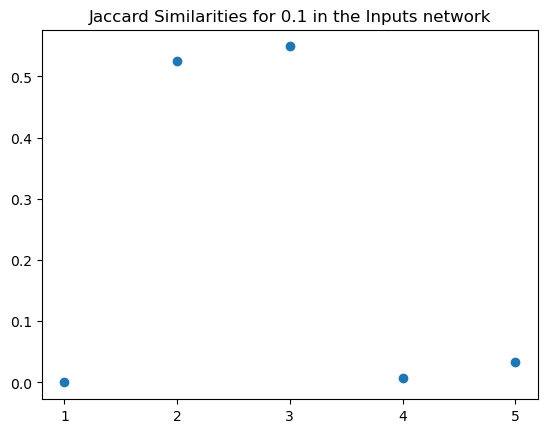

In [15]:
analysis(dict_pointone, '0.1', 'Inputs', "oviIN/Figures/inputs01_jaccard.png")


This is information about clusters [6, 15, 21, 23] compared with cluster 1
Neurons unique to clusters at chi value of 0.1:  261
Neurons unique to chi value of 0.0 of cluster 1:  518
Length of common neurons: 1
Jaccard similarity between zero cluster 1 and 0.1: 0.001282051282051282

This is information about clusters [1, 4, 5, 7, 10, 33] compared with cluster 2
Neurons unique to clusters at chi value of 0.1:  461
Neurons unique to chi value of 0.0 of cluster 1:  284
Length of common neurons: 432
Jaccard similarity between zero cluster 1 and 0.1: 0.36703483432455397

This is information about clusters [2, 3, 8] compared with cluster 3
Neurons unique to clusters at chi value of 0.1:  287
Neurons unique to chi value of 0.0 of cluster 1:  33
Length of common neurons: 554
Jaccard similarity between zero cluster 1 and 0.1: 0.6338672768878718

This is information about clusters [11] compared with cluster 4
Neurons unique to clusters at chi value of 0.1:  1
Neurons unique to chi value of 0.0 o

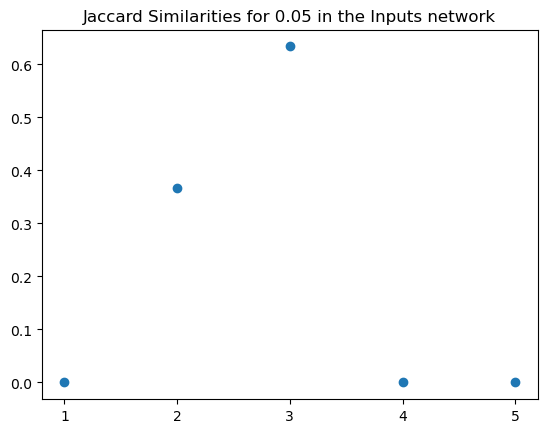

In [16]:
analysis(dict_point05, '0.05', 'Inputs', "oviIN/Figures/inputs005_jaccard.png")

In [25]:
## Outputs analysis
hemibrain_version = "v1.2.1"
log_msg("Hemibrain data set being used:", hemibrain_version)

preproc_dir = "oviIN/preprocessed_outputs-" + hemibrain_version
preproc_nodes = "preprocessed_nodes.csv"
preproc_centroids = "x"
preproc_edges = "preprocessed_undirected_edges.csv"

hemibrain_dir = "oviIN/clustering_outputs_" + hemibrain_version
hemibrain_nodes = "only_outputs_key.txt"
hemibrain_edges = "only_outputs.txt"

log_msg("Set up directory info and useful lists")

log_msg("Loading node dataframe")
if os.path.isfile(os.path.join(preproc_dir, preproc_centroids)):
    log_msg("  (with centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_centroids), index_col=0)
else:
    log_msg("  (without centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_nodes), index_col=0)
log_msg("Adding 'type group'")
HB_node_df["type_group"] = HB_node_df["celltype"].apply(simplify_type)
log_msg("Done!")

log_msg("Loading directed edges from csv")
HB_edge_df = pd.read_csv(os.path.join(hemibrain_dir, hemibrain_edges), delimiter=' ', header=None).rename(columns={0: "pre", 1:"post"})
log_msg("Done!")

log_msg("Merging in cell info to edge df")
HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='pre', right_index=True)
HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='post', right_index=True, suffixes=['pre', 'post'])
log_msg("Done!")

# Assigning 0.05 clusters to corresponding low res cluster (outputs)
c1_point05 = [1,7]
c2_point05 = [2,42,66]
c3_point05 = [4]
c4_point05 = [3,5,16]
c5_point05 =[6,38]
c6_point05 = [9,32,35]

# Assigning 0.1 clusters to corresponding low res cluster (outputs)
cluster1 = [1,6,7,31]
cluster2 = [2,60,79]
cluster3 = [4,114]
cluster4 = [5,11,24,57,62,67]
cluster5 = [8,22]
cluster6 = [3,16,42,58]

# Assigning 0.5 clusters to corresponding low res cluster (outputs)
c1_point5 = []
c2_point5 = []
c3_point5 = []
c4_point5 = []
c5_point5 = []
c6_point5 = []

# Cluster list for 0.05
cluster_point05 = [1,2,3,4,5,6]
clusters_list_05=[c1_point05, c2_point05, c3_point05, c4_point05, c5_point05, c6_point05]

# Cluster list for 0.1
cluster_pointone = [1,2,3,4,5,6]
clusters_list=[cluster1, cluster2, cluster3, cluster4, cluster5, cluster6]

# Clusters list for 0.5
cluster_point5 = [1,2,3,4,5,6]
clusters_list_05=[c1_point5, c2_point5, c3_point5, c4_point5, c5_point5, c6_point5]

# Pulling cluster for all clusters at 0.0
zero_cluster_list= create_lists(cluster_pointone, '0.0')

# Creating the dictionaries
dict_point05=create_dictionary(clusters_list_05, zero_cluster_list, cluster_point05)
dict_pointone=create_dictionary(clusters_list, zero_cluster_list, cluster_pointone)

2023 07 06 13:10:31  Hemibrain data set being used: v1.2.1
2023 07 06 13:10:31  Set up directory info and useful lists
2023 07 06 13:10:31  Loading node dataframe
2023 07 06 13:10:31    (without centroids)
2023 07 06 13:10:31  Adding 'type group'
2023 07 06 13:10:31  Done!
2023 07 06 13:10:31  Loading directed edges from csv
2023 07 06 13:10:31  Done!
2023 07 06 13:10:31  Merging in cell info to edge df
2023 07 06 13:10:31  Done!



This is information about clusters [1, 6, 7, 31] compared with cluster 1
Neurons unique to clusters at chi value of 0.1:  23
Neurons unique to chi value of 0.0 of cluster 1:  118
Length of common neurons: 594
Jaccard similarity between zero cluster 1 and 0.1: 0.8081632653061225

This is information about clusters [2, 60, 79] compared with cluster 2
Neurons unique to clusters at chi value of 0.1:  12
Neurons unique to chi value of 0.0 of cluster 1:  118
Length of common neurons: 483
Jaccard similarity between zero cluster 1 and 0.1: 0.7879282218597063

This is information about clusters [4, 114] compared with cluster 3
Neurons unique to clusters at chi value of 0.1:  4
Neurons unique to chi value of 0.0 of cluster 1:  11
Length of common neurons: 221
Jaccard similarity between zero cluster 1 and 0.1: 0.9364406779661016

This is information about clusters [5, 11, 24, 57, 62, 67] compared with cluster 4
Neurons unique to clusters at chi value of 0.1:  71
Neurons unique to chi value of 0.

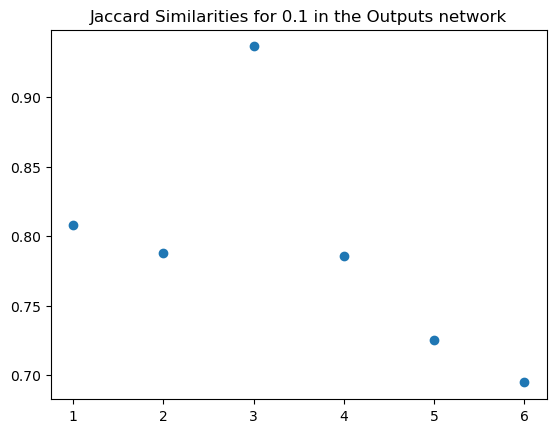

In [26]:
analysis(dict_pointone, '0.1', 'Outputs', "oviIN/Figures/outputs01_jaccard.png")


This is information about clusters [1, 7] compared with cluster 1
Neurons unique to clusters at chi value of 0.1:  37
Neurons unique to chi value of 0.0 of cluster 1:  107
Length of common neurons: 605
Jaccard similarity between zero cluster 1 and 0.1: 0.807743658210948

This is information about clusters [2, 42, 66] compared with cluster 2
Neurons unique to clusters at chi value of 0.1:  25
Neurons unique to chi value of 0.0 of cluster 1:  97
Length of common neurons: 504
Jaccard similarity between zero cluster 1 and 0.1: 0.805111821086262

This is information about clusters [4] compared with cluster 3
Neurons unique to clusters at chi value of 0.1:  0
Neurons unique to chi value of 0.0 of cluster 1:  14
Length of common neurons: 218
Jaccard similarity between zero cluster 1 and 0.1: 0.9396551724137931

This is information about clusters [3, 5, 16] compared with cluster 4
Neurons unique to clusters at chi value of 0.1:  187
Neurons unique to chi value of 0.0 of cluster 1:  123
Length

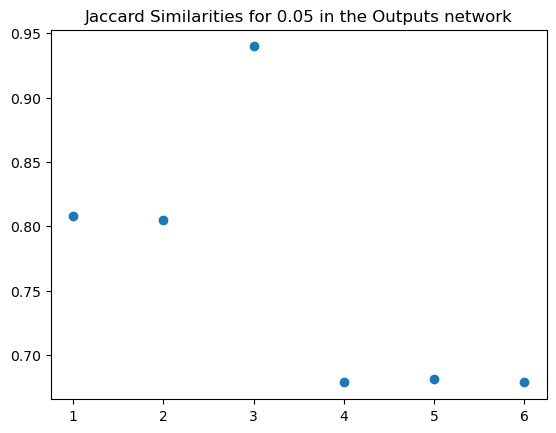

In [27]:
analysis(dict_point05, '0.05', 'Outputs', "oviIN/Figures/outputs005_jaccard.png")

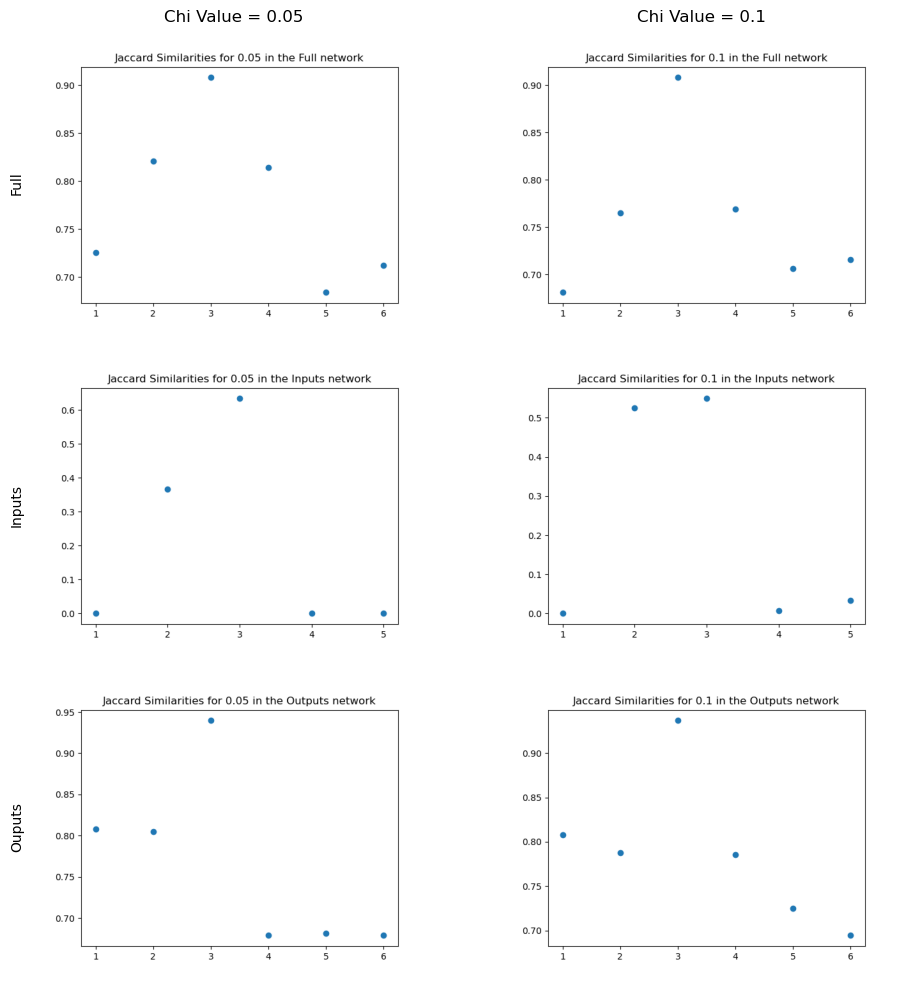

In [28]:
# Create a 2x3 subplot grid
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Import and display the first plot
image1 = plt.imread('oviIN/Figures/full01_jaccard.png')
image2 = plt.imread('oviIN/Figures/full005_jaccard.png')
image3 = plt.imread('oviIN/Figures/inputs01_jaccard.png')
image4 = plt.imread('oviIN/Figures/inputs005_jaccard.png')
image5 = plt.imread('oviIN/Figures/outputs01_jaccard.png')
image6 = plt.imread('oviIN/Figures/outputs005_jaccard.png')
axes[0, 0].imshow(image2)
axes[0, 0].set_ylabel('Full')
axes[0, 0].set_title('Chi Value = 0.05')
axes[0, 0].spines['top'].set_visible(False)
axes[0, 0].spines['right'].set_visible(False)
axes[0, 0].spines['bottom'].set_visible(False)
axes[0, 0].spines['left'].set_visible(False)
axes[0, 0].get_xaxis().set_ticks([])
axes[0, 0].get_yaxis().set_ticks([])

axes[0, 1].imshow(image1)
axes[0, 1].axis('off')
axes[0, 1].set_title('Chi Value = 0.1')

axes[1, 0].imshow(image4)
axes[1, 0].set_ylabel('Inputs')
axes[1, 0].spines['top'].set_visible(False)
axes[1, 0].spines['right'].set_visible(False)
axes[1, 0].spines['bottom'].set_visible(False)
axes[1, 0].spines['left'].set_visible(False)
axes[1, 0].get_xaxis().set_ticks([])
axes[1, 0].get_yaxis().set_ticks([])

axes[1, 1].imshow(image3)
axes[1, 1].axis('off')

axes[2, 0].imshow(image6)
axes[2, 0].set_ylabel('Ouputs')
axes[2, 0].spines['top'].set_visible(False)
axes[2, 0].spines['right'].set_visible(False)
axes[2, 0].spines['bottom'].set_visible(False)
axes[2, 0].spines['left'].set_visible(False)
axes[2, 0].get_xaxis().set_ticks([])
axes[2, 0].get_yaxis().set_ticks([])

axes[2, 1].imshow(image5)
axes[2, 1].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the combined figure
plt.savefig('combined_plots.png')

# Show the combined figure
plt.show()